In [8]:
import numpy as np
import pandas as pd
import os
import shutil
from flashgeotext.geotext import GeoText
import re
import spacy


nlp_version = 'en_core_web_lg' # OR: 'en_core_web_trf'
nlp = spacy.load(nlp_version)

In [9]:
outdir="wos_processed_data"
record_col="UT (Unique WOS ID)"

In [10]:
kw_df = pd.read_excel(f"{outdir}/wos_keywords.xlsx")
wos = pd.read_excel(f"{outdir}/wos_processed.xlsx")
kw_df = kw_df[~kw_df["keyword_all"].isna()].copy()
wos_kwd_concat = kw_df.groupby(record_col,as_index=False).agg({'keyword_all': '; '.join})

In [11]:
kwd_nlp = pd.DataFrame(kw_df["keyword_all"].drop_duplicates())
kwd_nlp = kwd_nlp.rename(columns={"keyword_all":"Document"})
kwd_nlp["Type"] = "kw"
kwd_nlp[record_col] = "kw_"+(kwd_nlp.index).astype(str)
wos_nlp = wos.merge(wos_kwd_concat, on=record_col)
# wos_nlp["Document"] = wos_nlp["keyword_all"].fillna("").str.upper()
# wos_nlp["Document"] = wos_nlp["Article Title"].str.cat(wos_nlp[["Abstract"]].fillna(""), sep=' - ').str.upper()
wos_nlp["Document"] = wos_nlp["Article Title"].str.cat(wos_nlp[["Abstract", "keyword_all"]].fillna(""), sep=' - ').str.upper()
wos_nlp[[record_col, "Document"]].drop_duplicates()
wos_nlp["Type"] = "doc"

tnse_nlp = pd.concat([kwd_nlp,wos_nlp], ignore_index=True)
tnse_nlp = tnse_nlp[[record_col,"Type","Document","keyword_all"]]

<Axes: ylabel='Frequency'>

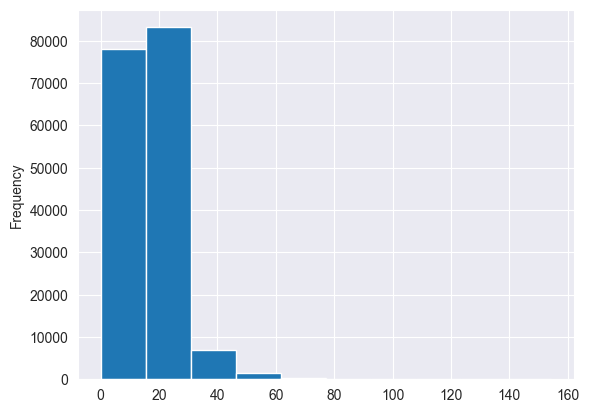

In [12]:
vectors = list()
vector_norms = list()

for doc in nlp.pipe(tnse_nlp['Document'].astype('unicode').values, batch_size=300,
                    n_process=4):
    if nlp_version == 'en_core_web_trf':
        trf_vector = doc._.trf_data.tensors[-1].mean(axis=0)
        trf_norm = np.linalg.norm(doc._.trf_data.tensors[-1].mean(axis=0))
        norm_vector = trf_vector/trf_norm
        vectors.append(norm_vector)
        vector_norms.append(np.linalg.norm(norm_vector))
    else:
        vectors.append(doc.vector)
        vector_norms.append(doc.vector_norm)


tnse_nlp['vector'] = vectors
tnse_nlp['vector_norm'] = vector_norms
tnse_nlp['vector_norm'].plot(kind="hist")

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

vector_data = pd.DataFrame(tnse_nlp["vector"].to_list(), index=tnse_nlp[record_col]).reset_index()
vector_data.head()

labels = vector_data.values[:, 0]
record_vectors = vector_data.values[:, 1:]

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42, metric='cosine')
tnse_2d = tsne_model.fit_transform(record_vectors)
tnse_data = pd.DataFrame(tnse_2d, index=labels).reset_index()
tnse_data.columns = [record_col, "TNSE-X", "TNSE-Y"]
tnse_data.head()


KeyboardInterrupt



In [ ]:
wos_plot = tnse_nlp.merge(tnse_data, on=record_col)

g = sns.scatterplot(wos_plot, x="TNSE-X", y="TNSE-Y",
                    hue='Type', s=1)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)